<h1 style="text-align:left;">Clustering: Equipos Europeos en sus ligas domésticas</h1>

En este caso tenemos un set de datos donde cada muestra corresponde a un equipo en la temporada 2018/2019. Y en este set de datos tenemos el xG y el xGA del equipo en toda la temporada en su liga doméstica.
<br>
Teniendo este set de datos, queremos hacer un análisis de los equipos en base al xG y el xGA y comprender qué equipos son más parecidos o formarían parte de un cluster. Así podríamos no solo sacar conclusiones acerca de ello, sino mejorarlo introduciendo nuevos datos o bien utilizar este estudio como un EDA para transformar los datos y utilizarlos en otro sistema de predicción.

In [1]:
# Cargamos las librerías

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sn

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [2]:
# Cargamos el dataset
dt = pd.read_csv('data/Clustering.csv')

Vemos los datos para hacernos una idea de cómo son.

In [3]:
dt.head()

,TeamName,Season,xG,xGA
0,Paris Saint-Germain FC,2018-2019,90.8,36.0
1,Manchester City FC,2018-2019,82.0,25.5
2,FC Bayern Munich,2018-2019,81.3,25.8
3,Olympique Lyonnais,2018-2019,73.8,42.8
4,Liverpool FC,2018-2019,73.6,30.0


Importante conocer las variables y el tipo de dato que tienen, así nos empezamos a orientar.

In [4]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TeamName  98 non-null     object 
 1   Season    98 non-null     object 
 2   xG        98 non-null     float64
 3   xGA       98 non-null     float64
dtypes: float64(2), object(2)
memory usage: 3.2+ KB


Como ocurre en la mayoría de modelos de Machine Learning, por no decir en todos, escalar los datos es un buen paso previo para intentar mejorar los resultados, así que aquí lo haremos.

In [5]:
dt['xG_std'] = dt['xG']
dt['xGA_std'] = dt['xGA']

dt[['xG_std', 'xGA_std']] = StandardScaler().fit_transform(dt[['xG', 'xGA']])

Vamos a visualizar los datos para entenderlos mejor: mostramos el xG vs xGA (escalados ambos).

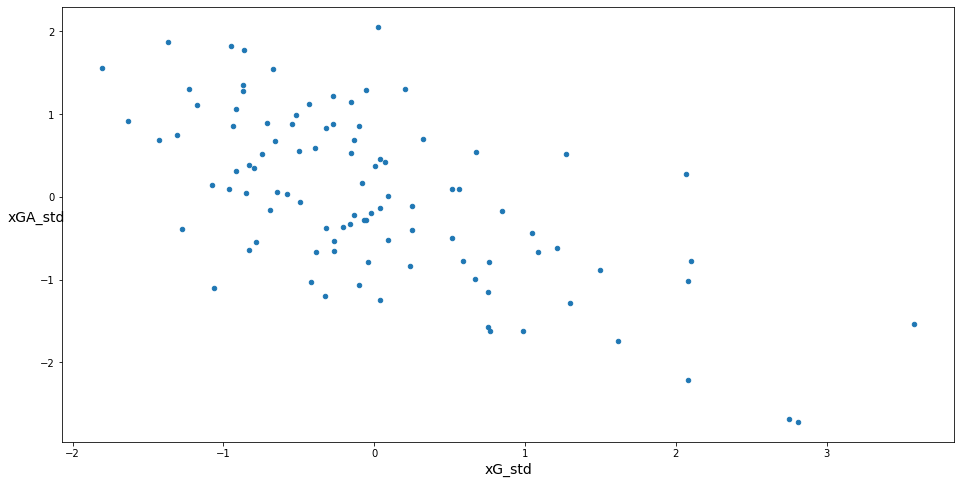

In [6]:
X = dt[['xG_std', 'xGA_std']].values
plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=None, s=20)
plt.xlabel("xG_std", fontsize=14)
plt.ylabel("xGA_std", fontsize=14, rotation=0)
plt.show()

Vemos que son datos que están ciertamente relacionados, y <strong>no hay unos grupos claros.</strong> Algunos están muy alejados de otros, pero no tenemos claro si lo suficientemente separado como para trabajar bien con algoritmos de clustering.

Vamos a crear unas funciones que serán utilizadas a lo largo del notebook, para no repetir el código continuamente.

Con Exec_KMeans queremos pasarle los datos de entrada y el número de clusters, para que nos resuelva los clusters y podamos dibujarlos.

In [7]:
def Exec_KMeans(k, X):
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_pred = kmeans.fit_predict(X)
    
    print("Centros de los clusters: ", kmeans.cluster_centers_)
    
    plt.figure(figsize=(16, 6))
    cl = ['red', 'green', 'blue', 'yellow', 'black']
    assign = []
    for row in y_pred:
        assign.append(cl[row])
        
    plt.scatter(X[:,0], X[:,1], c=assign, s=70)
    
    plt.show()
    
    return y_pred

<strong>El algoritmo de Clustering que vamos a utilizar es el KMeans</strong>, y vamos a hacer una primera prueba con 5 clusters para ver cómo se resuelve.

Centros de los clusters:  [[ 1.14737272 -0.9083889 ]
 [-0.96816319  1.00628737]
 [-0.31987911 -0.44900964]
 [ 2.8066213  -2.29037556]
 [ 0.06061785  0.72766211]]


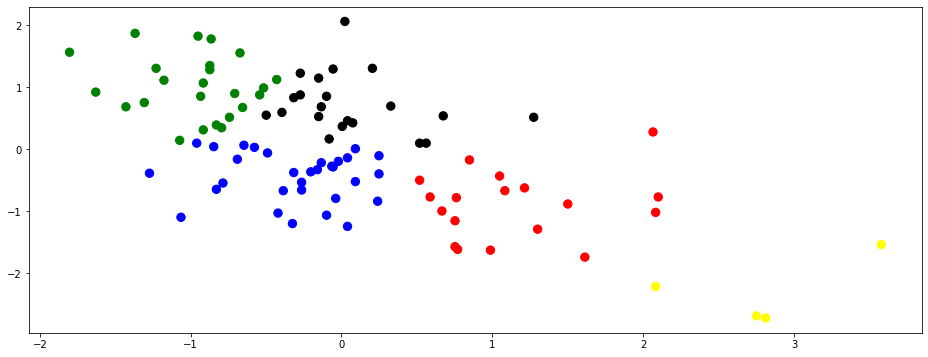

In [8]:
K=5
y_pred = Exec_KMeans(K, X)

Podemos ver cómo nos devuelve la posicion de los centros de cada cluster y la visualización de los datos separados por los clusters que hemos seleccionado.

<strong>No parece que sea una división optima</strong>, ¿verdad? Tenemos una zona amarilla con muchos datos separados, lo cual no tiene mala pinta... pero los puntos verdes, azules y negros tienen un aspecto muy feo, parece que puede ser fuente de errores ya que hay muchas muestras que rozan los bordes de los clusters y puede inducir a error en el futuro cuando quiera el algoritmo asignar a un equipo en un cluster determinado. Por lo que parece que este número de clusters no es muy interesante.

Podemos ver a continuación lo que devuelve KMeans, no es más que el id del cluster al que pertenece la muestra, empezando desde 0.

In [9]:
y_pred

array([3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 4, 4, 0, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2,
       4, 2, 4, 4, 2, 4, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2, 4, 2, 1, 2, 4,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 1])

<strong>Pero...¿así comprobamos si el número de clusters es el ideal?</strong> No, simplemente es una visualización. Hay diferentes formas de comprobar si el KMeans funciona como esperamos y cómo seleccionar el número correcto de clusters. Aquí veremos algunas de ellas.

Vamos a usar tres pasos:
 - El cálculo de la inercia. Podremos ver cómo según tenemos más clusters, la inercia baja.
 - El cálculo del silhouette score. Podremos ver cómo hay un score que nos indica si es interesante ese número de clusters o no.
 - El diagrama de silhouette. Podremos comparar diferentes clusters y ver cual es idóneo para nuestro estudio.
 
Empezamos con la inercia:

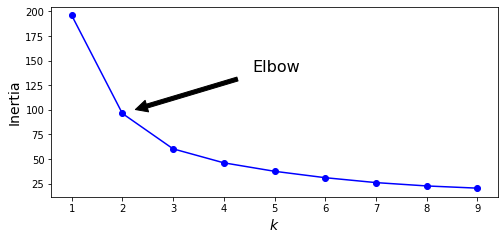

In [10]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.5, 0.7),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

Podemos ver cómo a partir del K=2 (2 clusters) hay un 'codo' que nos indica que a partir de ahí sigue bajando la inercia pero no en grandísima medida, no es igual de brusco. <strong>El cálculo de la inercia no es una buena forma de medir el número de clusters, porque cuantos más clusters haya menor es la inercia entonces no sabremos donde parar. Pero sí nos dice donde hay un 'codo' o lugar en el que varía susceptiblemente y es un número a tener en cuenta.</strong> Donde a partir de ahí empieza a no bajar tan bruscamente. Es evidente que si tenemos tantos clusters como muestras, la ineria será 0. Pero no queremos tener un cluster por equipo, sería ilógico porque no sería clustering. Por ello debemos barajar opciones en torno al 'codo' para elegir nuestro número k (el número de clusters).

Vamos a analizar el silhouette score.

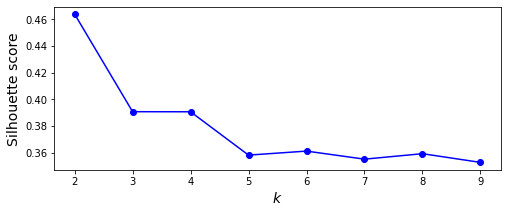

In [11]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

<strong>Con este coeficiente podemos entender mejor cual es el número ideal de clusters a seleccionar.</strong> Este coeficiente va de +1 a -1, y cuanto más cerca de 1 esté mejor. Cuando está en 1 dice que las muestras tienden a estar bien en su cluster, cuando tiende a 0 dice que las muestras están rozando los bordes de los clusters (como hemos visto en la visualización inicial, que había poca separación) y cuando tiende a -1 dice que las muestras pueden estar asignados erróneamente a un cluster diferente.

En este caso vemos que con el número 2 tenemos el mejor score, y luego con el 3 es inferior, no mucho peor, pero algo inferior. En torno a un 0,8. Y vemos que 3 clusters y 4 clusters ofrecen un score muy similar. Interesante.

Vamos a echar un vistazo al diagrama de los diferentes coeficientes agrupados y ordenados por cluster, para poder ver la cantidad de equipos que hay por cada uno y entender cómo está cada cluster.

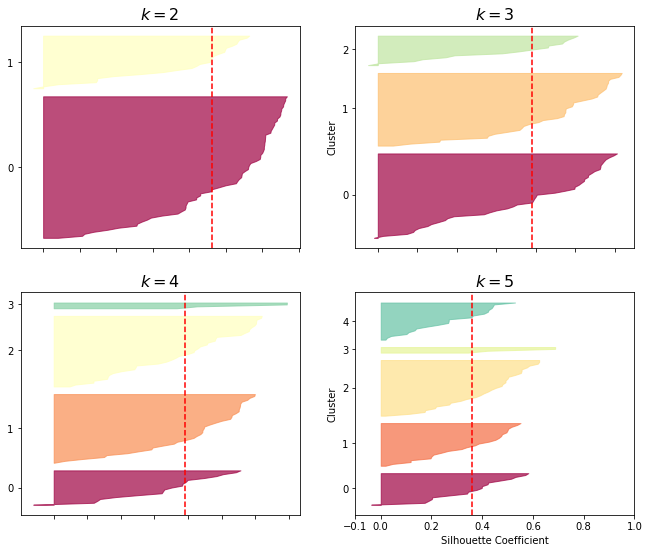

In [12]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Podemos comprobar cómo con 2 clusters tenemos uno de ellos con una cantidad muy superior de muestras, y <strong>eso es algo que queremos evitar. Buscamos tener una relación más o menos igual en los diferentes clusters para que la agrupación sea lógica.</strong>

Con 3 clusters ya mejora la cantidad de muestras, recordemos que comparándolo con k=2 la inercia era menor pero el score sólo ligeramente inferior.

Con 4 clusters tenemos una mayor dispersión, sigue habiendo gran diferencia entre clusters, además podemos ver que el score era muy parecido a k=3. Por lo que tenemos un cluster extra que no nos ofrece una mayor información.

Analizando estos resultados, podríamos elegir un k=3:
 - La inercia es buena y está pegada al codo que hemos visto anteriormente.
 - El score es el segundo mejor, y no es tan diferente al primero. Un precio que podríamos pagar.
 - Dicho esto parece que podríamos elegir k=2, pero la cantidad de muestras es muy diferente entre clusters y podría ocasionar problemas, por lo que parece que el segundo candidato (k=3) es mejor. Además esta elección es mejor que k=4, el cual mejora ligeramente la inercia pero no así el score, y genera ruido añadir más clusters de los necesarios si no nos ofrece información interesante.
 
<strong>Por lo que nuestra elección sería K=3.</strong>


Vamos a mostrar cómo sería la visualización con diferentes clusters:

Centros de los clusters:  [[-0.46491539  0.41332497]
 [ 1.22255528 -1.0868916 ]]


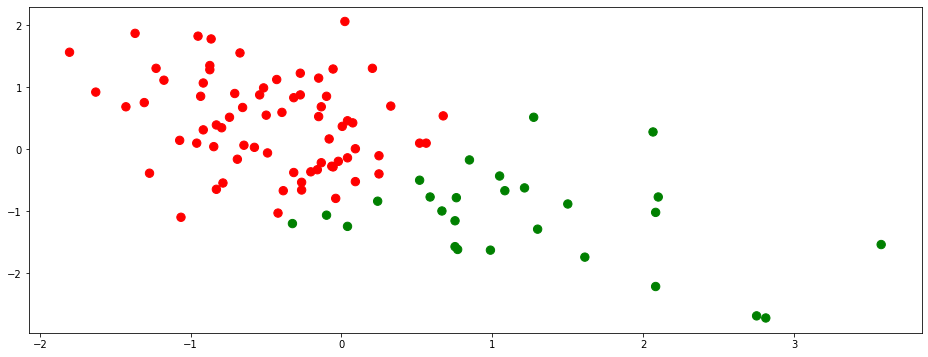

In [13]:
K=2
y_pred = Exec_KMeans(K, X)

Centros de los clusters:  [[-0.03318525 -0.34127986]
 [-0.6839281   0.97029015]
 [ 1.71558868 -1.36591949]]


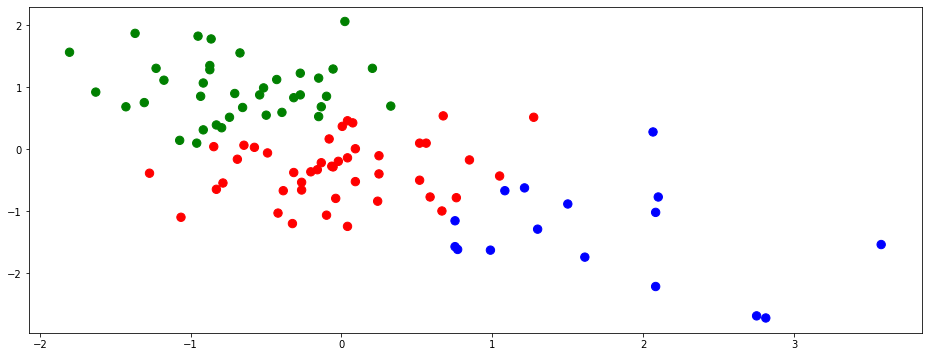

In [14]:
K=3
y_pred = Exec_KMeans(K, X)

Centros de los clusters:  [[ 1.15405806 -0.83352655]
 [-0.67647124  0.99389629]
 [-0.21379348 -0.30988568]
 [ 2.8066213  -2.29037556]]


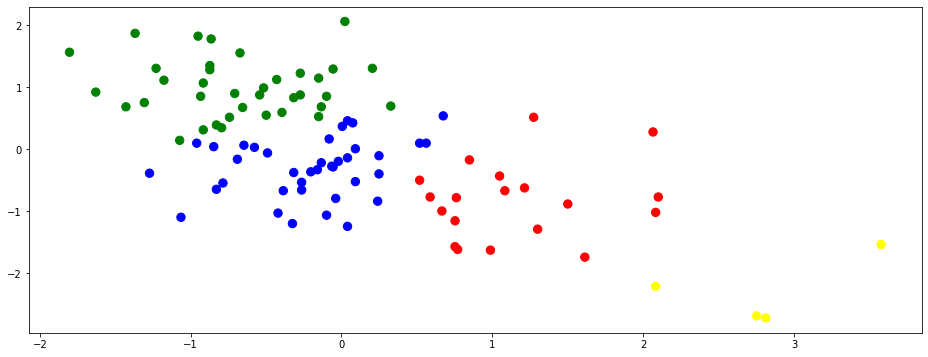

In [15]:
K=4
y_pred = Exec_KMeans(K, X)

Centros de los clusters:  [[ 1.14737272 -0.9083889 ]
 [-0.96816319  1.00628737]
 [-0.31987911 -0.44900964]
 [ 2.8066213  -2.29037556]
 [ 0.06061785  0.72766211]]


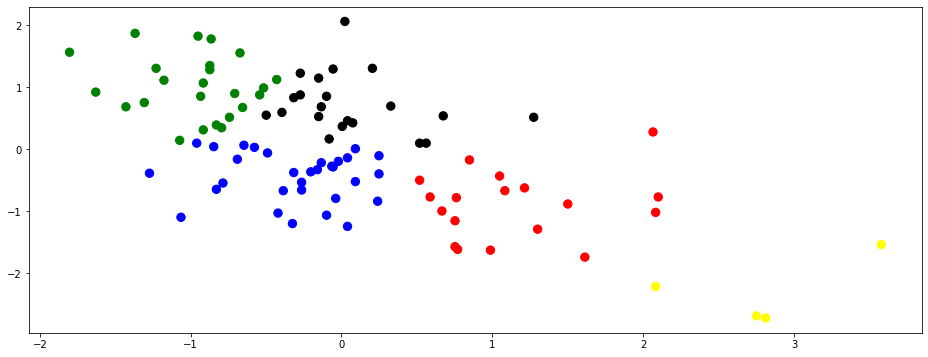

In [16]:
K=5
y_pred = Exec_KMeans(K, X)

Efectivamente podemos ver cómo con 3 clusters tenemos una agrupación interesante entre muestras que ofrece cierta diferenciación.

<strong>Vemos los problemas de que muchas muestras rozan el borde los clusters,</strong> de ahí que el silhouette score sea algo bajo, pero de entre todas las opciones y analizando la visualización parece suficiente para comprender cómo son nuestros datos.

Centros de los clusters:  [[-0.03318525 -0.34127986]
 [-0.6839281   0.97029015]
 [ 1.71558868 -1.36591949]]


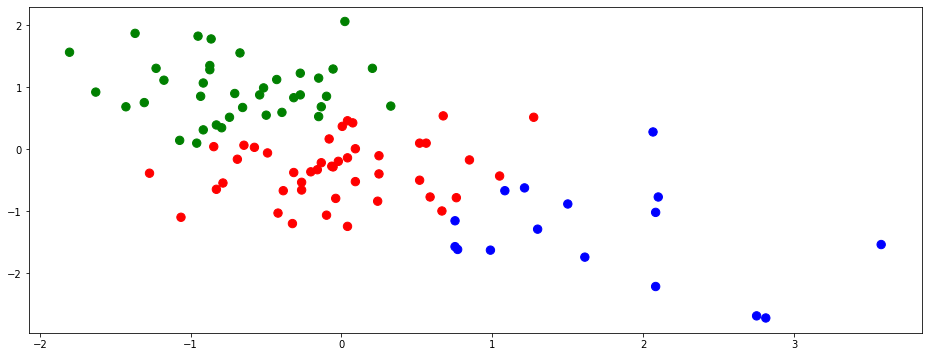

,TeamName,Season,xG,xGA,xG_std,xGA_std,Cluster
0,Paris Saint-Germain FC,2018-2019,90.8,36.0,3.578168,-1.537846,2
1,Manchester City FC,2018-2019,82.0,25.5,2.813141,-2.721600,2
2,FC Bayern Munich,2018-2019,81.3,25.8,2.752287,-2.687779,2
3,Olympique Lyonnais,2018-2019,73.8,42.8,2.100275,-0.771224,2
4,Liverpool FC,2018-2019,73.6,30.0,2.082889,-2.214277,2


In [17]:
selectedK = 3
dt['Cluster'] = Exec_KMeans(selectedK, X)

dt.head()

Ya que tenemos los clusters elegidos, hemos añadido los resultados en el dataset y así podríamos ver a qué cluster pertenece cada equipo.

Vamos a echar un <strong>vistazo estadístico a los clusters</strong> y así comprendemos por qué KMeans nos lo ha diferenciado así.

In [18]:
print("Cluster 0")
print("La media de los xG es ", round(dt[dt['Cluster']==0]['xG'].mean(), 2))
print("La media de los xGA es ", round(dt[dt['Cluster']==0]['xGA'].mean(), 2))
print("En este cluster podemos encontrar equipos que tienen un xG medio y un xGA medio.")
print("-----------")
print("Cluster 1")
print("La media de los xG es ", round(dt[dt['Cluster']==1]['xG'].mean(), 2))
print("La media de los xGA es ", round(dt[dt['Cluster']==1]['xGA'].mean(), 2))
print("En este cluster podemos encontrar equipos más defensivos, que no tienen mucho xG y si reciben mucho ataque.")
print("-----------")
print("Cluster 2")
print("La media de los xG es ", round(dt[dt['Cluster']==2]['xG'].mean(), 2))
print("La media de los xGA es ", round(dt[dt['Cluster']==2]['xGA'].mean(), 2))
print("En este cluster podemos encontrar equipos top, que tienden a atacar y a tener el balón, porque no les llegan mucho.")

Cluster 0
La media de los xG es  49.26
La media de los xGA es  46.61
En este cluster podemos encontrar equipos que tienen un xG medio y un xGA medio.
-----------
Cluster 1
La media de los xG es  41.77
La media de los xGA es  58.25
En este cluster podemos encontrar equipos más defensivos, que no tienen mucho xG y si reciben mucho ataque.
-----------
Cluster 2
La media de los xG es  69.38
La media de los xGA es  37.52
En este cluster podemos encontrar equipos top, que tienden a atacar y a tener el balón, porque no les llegan mucho.


Interesante, ¿verdad? <strong>El algoritmo ha decidido cómo se agruparían los diferentes equipos en base al xG y el xGA para categorizarlos </strong>y efectivamente vemos cómo <strong>tenemos 3 grandes tipos: un cluster de equipos atacantes y que tienen el balón, un cluster de equipos más defensivos que les llegan más y otro cluster de equipos en un término medio.</strong>

Esto nos lo ofrece KMeans.

A continuación podemos ver los diferentes equipos de cada cluster, para comprobar cuales son los que parece que juegan de forma similar (recordemos que estamos usando sólo dos variables, podríamos introducir muchas más para mejorar el algoritmo y que los clusters conjuguen a los equipos de mejor manera; usando densidad de redes, posesión, métricas de balón parado... cuantas más mejor (Big Data!!!)).

In [19]:
dt[dt['Cluster']==0].sort_values(by=['xG', 'xGA'], ascending=False)

,TeamName,Season,xG,xGA,xG_std,xGA_std,Cluster
10,AS Roma,2018-2019,64.3,54.2,1.274394,0.513996,0
13,Real Madrid CF,2018-2019,61.7,45.8,1.048364,-0.433008,0
15,Manchester United FC,2018-2019,59.4,48.1,0.848413,-0.173709,0
17,Lille OSC,2018-2019,58.4,42.7,0.761478,-0.782498,0
20,Arsenal FC,2018-2019,57.4,54.4,0.674544,0.536543,0
21,Valencia CF,2018-2019,57.3,40.8,0.665850,-0.996701,0
22,SS Lazio,2018-2019,56.4,42.8,0.587609,-0.771224,0
23,AS Saint-Étienne,2018-2019,56.1,50.5,0.561528,0.096863,0
24,Eintracht Frankfurt,2018-2019,55.6,50.5,0.518061,0.096863,0
25,Tottenham Hotspur FC,2018-2019,55.6,45.2,0.518061,-0.500651,0


In [20]:
dt[dt['Cluster']==1].sort_values(by=['xG', 'xGA'], ascending=False)

,TeamName,Season,xG,xGA,xG_std,xGA_std,Cluster
26,AFC Bournemouth,2018-2019,53.4,55.8,0.326804,0.694377,1
30,Empoli FC,2018-2019,52.0,61.2,0.205095,1.303166,1
37,Levante UD,2018-2019,49.9,67.9,0.022532,2.058514,1
41,West Ham United FC,2018-2019,49.0,61.1,-0.055709,1.291892,1
46,1. FSV Mainz 05,2018-2019,48.5,57.2,-0.099177,0.852211,1
47,Nîmes Olympique,2018-2019,48.1,55.7,-0.133951,0.683104,1
50,Hertha BSC,2018-2019,47.9,59.8,-0.151338,1.145332,1
49,Watford FC,2018-2019,47.9,54.3,-0.151338,0.525270,1
56,Fortuna Düsseldorf,2018-2019,46.5,60.5,-0.273046,1.224249,1
55,US Sassuolo Calcio,2018-2019,46.5,57.4,-0.273046,0.874759,1


In [21]:
dt[dt['Cluster']==2].sort_values(by=['xG', 'xGA'], ascending=False)

,TeamName,Season,xG,xGA,xG_std,xGA_std,Cluster
0,Paris Saint-Germain FC,2018-2019,90.8,36.0,3.578168,-1.537846,2
1,Manchester City FC,2018-2019,82.0,25.5,2.813141,-2.721600,2
2,FC Bayern Munich,2018-2019,81.3,25.8,2.752287,-2.687779,2
3,Olympique Lyonnais,2018-2019,73.8,42.8,2.100275,-0.771224,2
5,FC Barcelona,2018-2019,73.6,40.6,2.082889,-1.019248,2
4,Liverpool FC,2018-2019,73.6,30.0,2.082889,-2.214277,2
6,TSG 1899 Hoffenheim,2018-2019,73.4,52.1,2.065502,0.277245,2
7,SSC Napoli,2018-2019,68.2,34.2,1.613440,-1.740775,2
8,Atalanta BC,2018-2019,66.9,41.8,1.500425,-0.883962,2
9,Internazionale,2018-2019,64.6,38.2,1.300475,-1.289821,2


##### Referencias
Algunas de las funciones aquí utilizadas han sido extraidas del libro 'Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow, 2nd Edition, by Aurélien Géron (O'Reilly) Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9'.